In [1]:
%matplotlib inline
from os.path  import join
import Packages.DataLoaders as loader
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import Packages.model_package as model_package

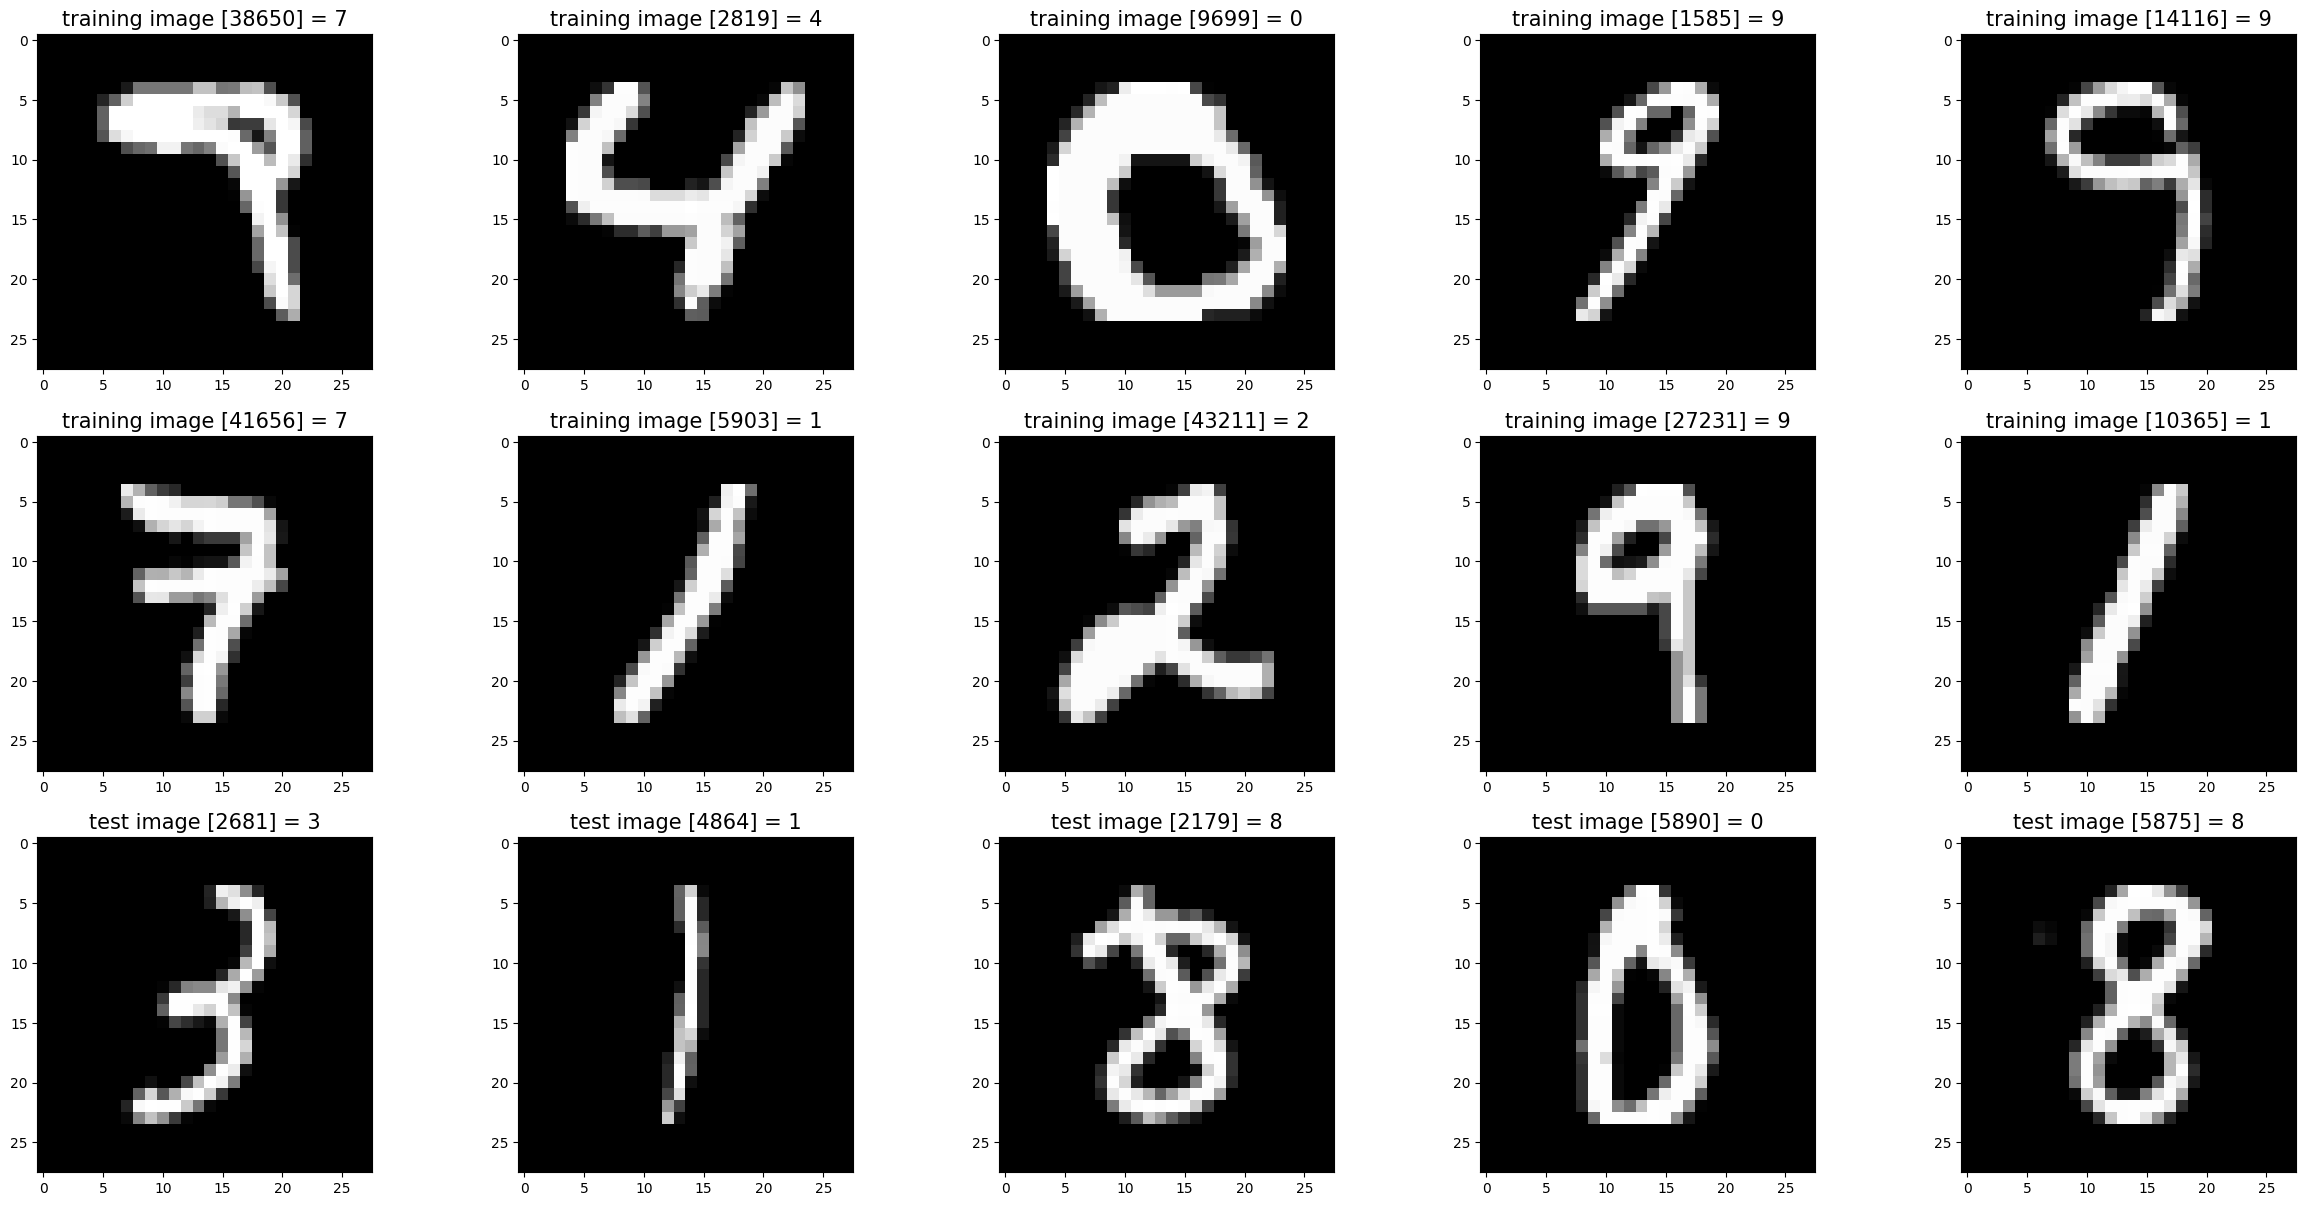

In [2]:

input_path = './Data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = loader.MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data_cropped()
n_train_first = len(x_train)
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [3]:
# Train with only digit data for testing purposes
# n_train_first = 0
# x_train = []
# y_train = []

In [4]:
font_loader = loader.FontDigitImageLoader(join(input_path,"Digits"),1)

In [5]:
font_images = font_loader.GetImages()
font_labels = font_loader.GetLabels()
x_train.extend(font_images)
y_train.extend(font_labels)

n_train_second = len(x_train)
print(n_train_second)

70160


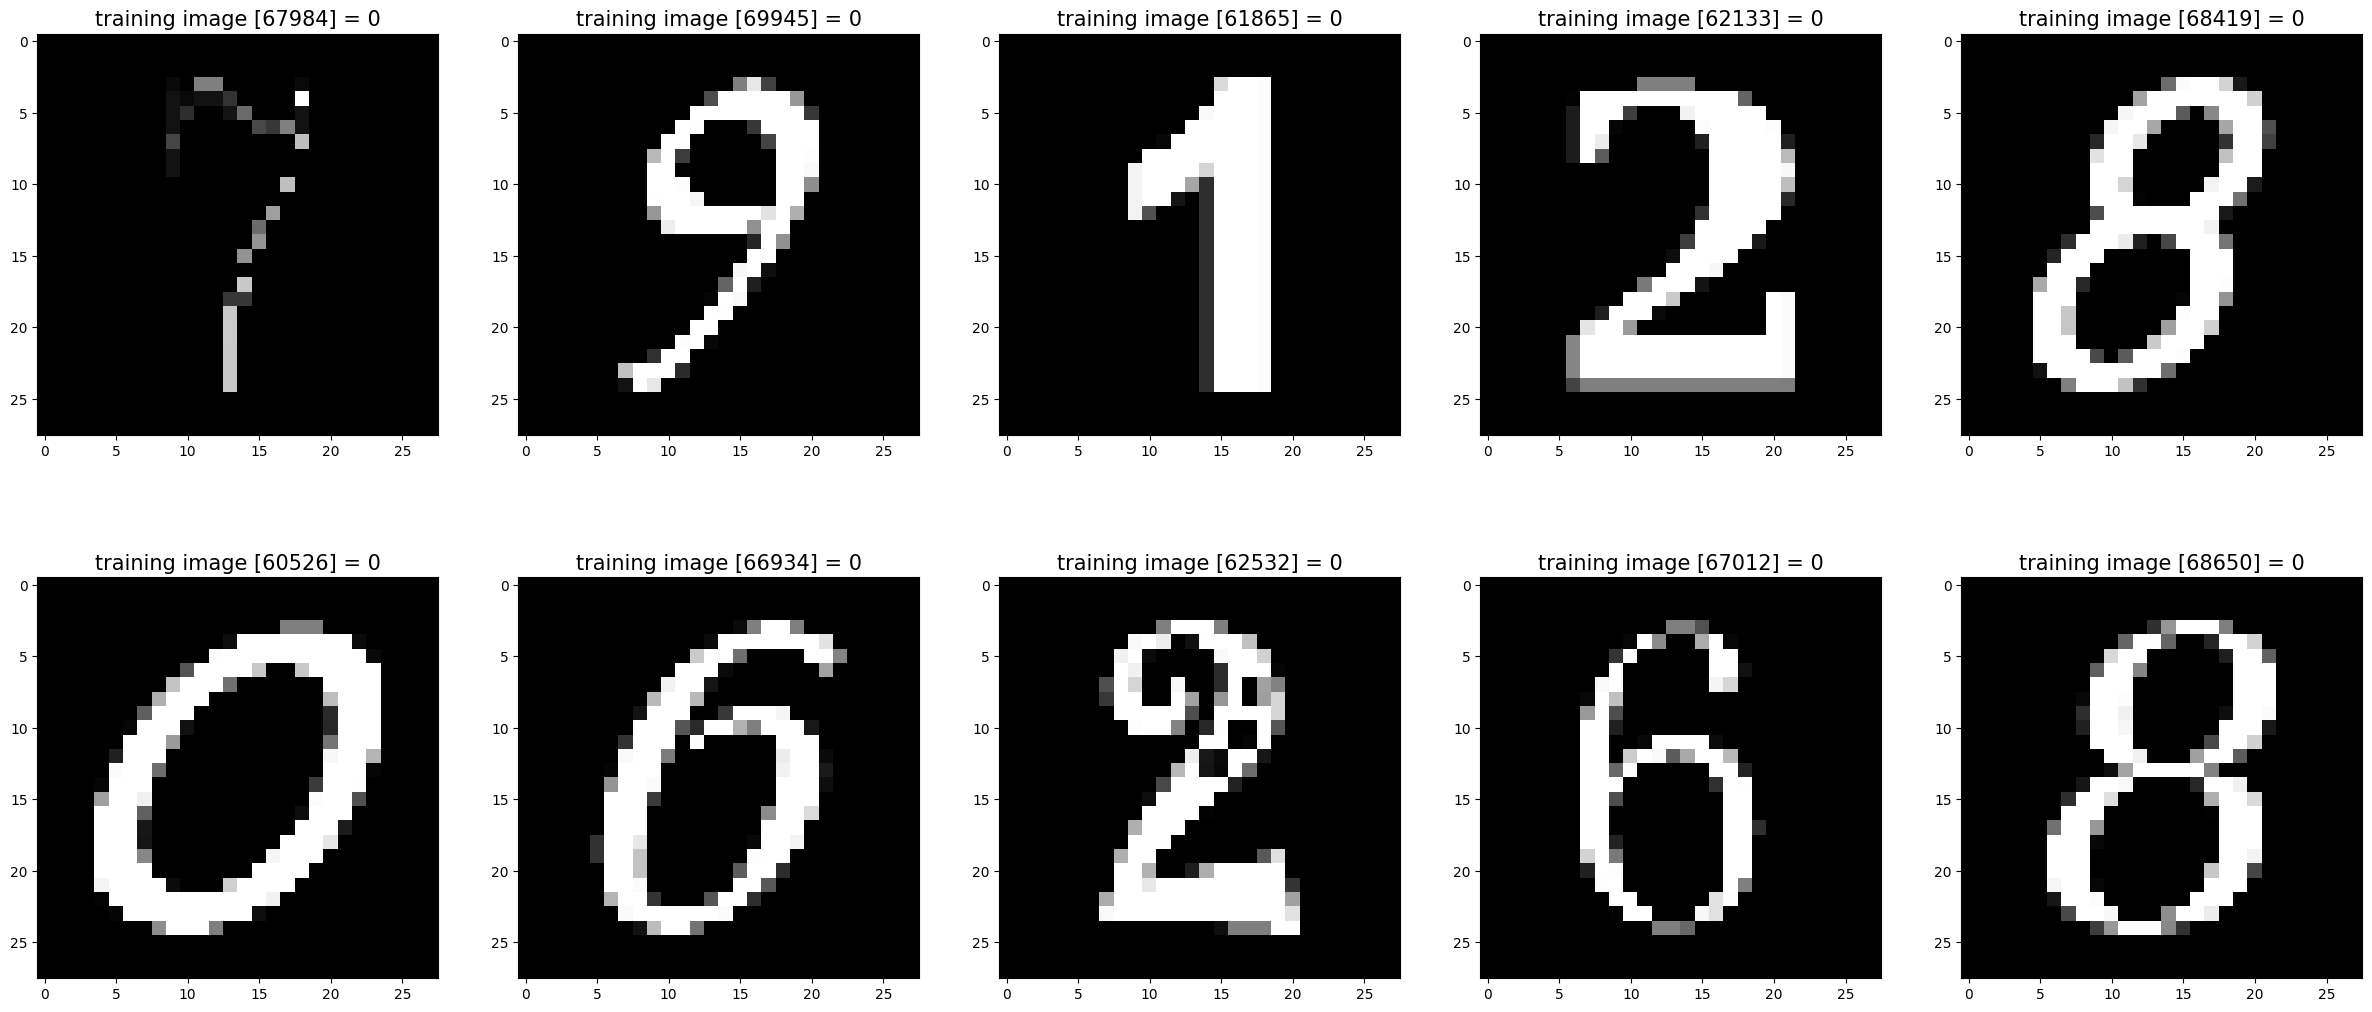

In [6]:
# Show some random font images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(n_train_first, n_train_second-1)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 
show_images(images_2_show, titles_2_show)

In [7]:
# Appending an empty image with 10 as label
x_train.append(np.zeros((28,28)))
y_train.append(10)
x_test.append(np.zeros((28,28)))
y_test.append(10)

# Change the weights so that the empty image becomes more important.
w = np.ones(11)
w[-1]=w[-1]*1000

In [8]:
# Using the sudokus as test data
sudoku_data = []
sudoku_labels = []

# Load the image
processor1 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku1.png"),number_path=join(input_path, "Sudokus/sudoku1.npy"))
processor1.create_digits(0.1)
(x1,y1) = processor1.to_test_data()
sudoku_data=sudoku_data+x1
sudoku_labels=sudoku_labels+y1
processor2 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku2.png"),number_path=join(input_path, "Sudokus/sudoku2.npy"))
processor2.create_digits(0.1)
(x2,y2) = processor2.to_test_data()
sudoku_data=sudoku_data+x2
sudoku_labels=sudoku_labels+y2

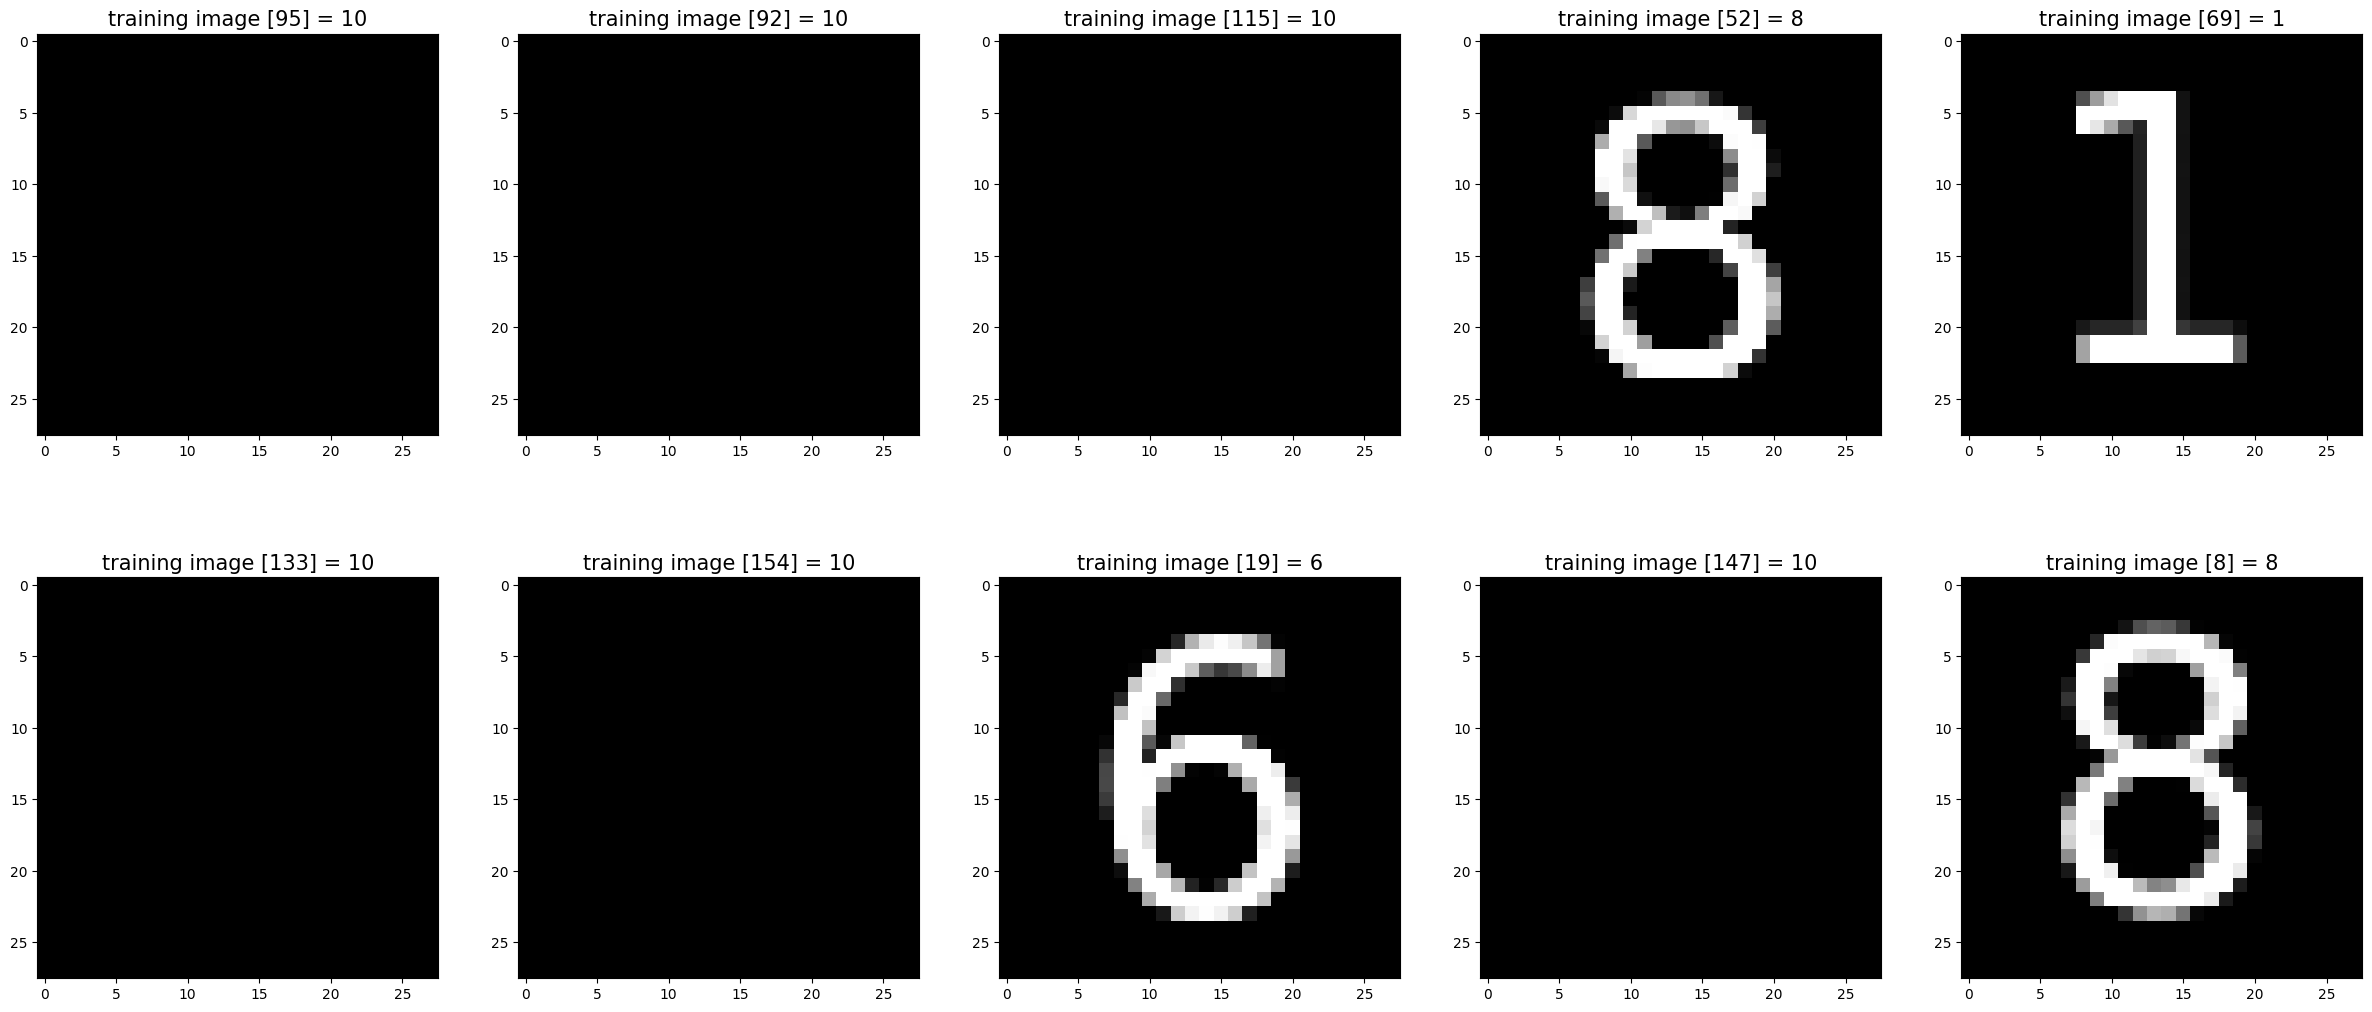

In [9]:
# Show some random sudoku images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(0, 2*9*9-1)
    images_2_show.append(sudoku_data[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(sudoku_labels[r])) 
show_images(images_2_show, titles_2_show)

In [10]:
print("Amount of training data: " + str(len(x_train)))

Amount of training data: 70161


In [11]:
trainer = model_package.ModelTrainer(x_train, y_train, x_test, y_test, sudoku_data, sudoku_labels, w)
(score_test,score_sudoku,model) = trainer.OneSeedProgram(7,30,decision_mode = "sudoku_only",model_mode="ConvolutionalNN")
torch.save(model.state_dict(), "model")
# model = models.ConvolutionalNN()
# model.load_state_dict(torch.load("model"))
# model.eval()

Epoch 1/30, Loss: 0.278705300745421
Epoch 1/30, Accuracy on the test set: 97.79%
Epoch 1/30, Accuracy on the sudoku set: 46.91%
Epoch 2/30, Loss: 0.0634132409023644
Epoch 2/30, Accuracy on the test set: 98.23%
Epoch 2/30, Accuracy on the sudoku set: 83.33%
Epoch 3/30, Loss: 0.04853219174752466
Epoch 3/30, Accuracy on the test set: 98.27%
Epoch 3/30, Accuracy on the sudoku set: 81.48%
Epoch 4/30, Loss: 0.0387785108594516
Epoch 4/30, Accuracy on the test set: 97.87%
Epoch 4/30, Accuracy on the sudoku set: 99.38%
Epoch 5/30, Loss: 0.03486768395137789
Epoch 5/30, Accuracy on the test set: 98.46%
Epoch 5/30, Accuracy on the sudoku set: 93.21%
Epoch 6/30, Loss: 0.030727857035232717
Epoch 6/30, Accuracy on the test set: 98.45%
Epoch 6/30, Accuracy on the sudoku set: 84.57%
Epoch 7/30, Loss: 0.02681636605982304
Epoch 7/30, Accuracy on the test set: 98.06%
Epoch 7/30, Accuracy on the sudoku set: 91.98%
Epoch 8/30, Loss: 0.02445933513343719
Epoch 8/30, Accuracy on the test set: 98.66%
Epoch 8/30

KeyboardInterrupt: 

In [ ]:
print(model.forward(torch.from_numpy(np.zeros((28,28))).float()))

In [ ]:
"""
# This is for when we want to run over multiple seeds
import Packages.priorityQueue as pq

q = pq.PriorityQueue(3)
for i in range(10):
    print("Seed number: "str(i))
    q.AddElement(OneSeedProgram(i,15))
print(q.getList())
"""

In [ ]:
arr = processor.predictions(model)
print(arr)

In [ ]:
print(processor.get_numbers())